<a href="https://colab.research.google.com/github/butchland/fastai_xla_extensions/blob/master/explore_nbs/debug3MNIST_TPU_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FastAI XLA Extensions MNIST Demo

* updating pytorch xla install to use Pytorch XLA 1.6 release (official)
* update to use fastai to 2.0.0 and fastcore 1.0.0
since pytorch xla 1.6 install is not working with old version of fastai and fastcore
* update to use MNIST_SAMPLE
* using `pretrained = False` 
* using `lr_find`, `lr_max=slice(2.8e-3, 0.012)` 
* accuracy after 10 epochs - 100 percent

In [1]:
#hide_input
#colab
import os
assert os.environ['COLAB_TPU_ADDR'], 'Make sure to select TPU from Edit > Notebook settings > Hardware accelerator'

In [2]:
#hide
#colab
!curl -s https://course19.fast.ai/setup/colab | bash 

Updating fastai...
Done.


Install fastai2 and the fastai_xla_extensions packages

In [3]:
!pip install -Uqq fastcore==1.0.0

In [4]:
#hide_output
#colab
!pip install -Uqq fastai==2.0.0

In [5]:
#hide_output
#ci
!pip install -Uqq  git+https://github.com/butchland/fastai_xla_extensions.git

In [6]:
!pip install -Uqq cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.6-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 131.2MB 89kB/s 
     |████████████████████████████████| 61kB 2.7MB/s 


In [7]:
#hide_output
#colab
# VERSION = "20200325"  #@param ["1.5" , "20200325", "nightly"]
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version $VERSION

In [14]:
!pip freeze | grep torch
!pip freeze | grep fastai
!pip freeze | grep fastcore
!pip freeze | grep fastai-xla-extensions

torch==1.6.0+cu101
torch-xla==1.6
torchsummary==1.5.1
torchtext==0.3.1
torchvision==0.7.0+cu101
fastai==2.0.0
fastai-xla-extensions==0.0.1
fastcore==1.0.0
fastai-xla-extensions==0.0.1


### Import the libraries
Import the fastai2 and fastai_xla_extensions libraries

In [9]:
#colab
import fastai_xla_extensions.core

**IMPORTANT: Make sure to import fastai_xla_extensions.core BEFORE importing fastai2 libraries** 

If you don't, fastai2 will not default to use tpu device but will instead use the cpu.

In [10]:
from fastai.vision.all import *

### Example
Build a MNIST classifier -- adapted from fastai course [Lesson 4 notebook](https://github.com/fastai/course-v4/blob/master/nbs/04_mnist_basics.ipynb)

Load MNIST dataset 

In [11]:
path = untar_data(URLs.MNIST_SAMPLE)

In [12]:
#hide
Path.BASE_PATH = path

In [13]:
path.ls()

(#3) [Path('valid'),Path('train'),Path('labels.csv')]

Create Fastai DataBlock


_Note that batch transforms are currently
set to none as they seem to slow the training
on the TPU (for investigation)._

In [15]:
datablock = DataBlock(
    blocks=(ImageBlock,CategoryBlock),
    get_items=get_image_files,
    splitter=GrandparentSplitter(),
    get_y=parent_label,
    item_tfms=Resize(28),
    batch_tfms=[]
)

In [16]:
#colab
datablock.summary(path)

Setting-up type transforms pipelines
Found 14434 items
2 datasets of sizes 12396,2038
Setting up Pipeline: PILBase.create
Setting up Pipeline: parent_label -> Categorize -- {'vocab': None, 'add_na': False}

Building one sample
  Pipeline: PILBase.create
    starting from
      /root/.fastai/data/mnist_sample/train/7/22955.png
    applying PILBase.create gives
      PILImage mode=RGB size=28x28
  Pipeline: parent_label -> Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False}
    starting from
      /root/.fastai/data/mnist_sample/train/7/22955.png
    applying parent_label gives
      7
    applying Categorize -- {'vocab': (#2) ['3','7'], 'add_na': False} gives
      TensorCategory(1)

Final sample: (PILImage mode=RGB size=28x28, TensorCategory(1))


Setting up after_item: Pipeline: Resize -- {'size': (28, 28), 'method': 'crop', 'pad_mode': 'reflection'} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1}

Create the dataloader

In [17]:
dls = datablock.dataloaders(path)

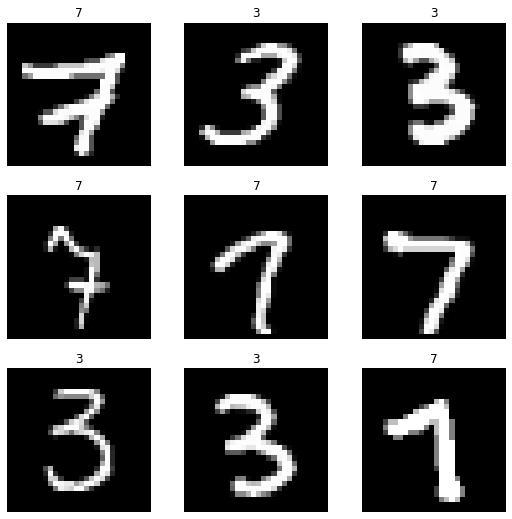

In [18]:
#colab
dls.show_batch()

Create a Fastai CNN Learner

In [19]:
#colab
learner = cnn_learner(dls, resnet18, metrics=accuracy, pretrained=False)
                      

In [20]:
learner.xla_opt

XLAOptCallback

In [21]:
learner.summary()

Sequential (Input shape: ['64 x 3 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               64 x 64 x 14 x 14    9,408      True      
________________________________________________________________
BatchNorm2d          64 x 64 x 14 x 14    128        True      
________________________________________________________________
ReLU                 64 x 64 x 14 x 14    0          False     
________________________________________________________________
MaxPool2d            64 x 64 x 7 x 7      0          False     
________________________________________________________________
Conv2d               64 x 64 x 7 x 7      36,864     True      
________________________________________________________________
BatchNorm2d          64 x 64 x 7 x 7      128        True      
________________________________________________________________
ReLU                 64 x 64 x 7 x 7      0          False     
___________________________________________________

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.0002754228771664202)

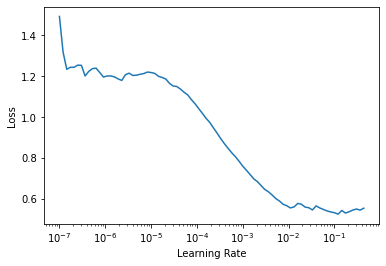

In [22]:
learner.lr_find()

In [23]:
learner.fit_one_cycle(10, lr_max=slice(2.8e-3, 0.012))

epoch,train_loss,valid_loss,accuracy,time
0,0.058642,0.039365,0.989205,00:35
1,0.056339,0.095707,0.970559,00:25
2,0.043474,0.247087,0.909715,00:25
3,0.030221,0.010058,0.997056,00:25
4,0.024373,0.029081,0.993621,00:25
5,0.018856,0.003650,0.999509,00:25
6,0.010818,0.002552,0.999019,00:27
7,0.001595,0.000056,1.000000,00:26
8,0.000738,0.002167,0.999509,00:28
9,0.000237,0.000101,1.000000,00:25
